In [1]:
#pip install git+https://github.com/artemmavrin/focal-loss.git

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from keras.saving import register_keras_serializable
#from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam




# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [3]:
# Load the compressed dataset
data = np.load("/kaggle/input/screamofsium/mars_datasets_aug.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (4589, 64, 128, 1)
y_train shape: (4589, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


In [4]:
input_shape = (64, 128, 1)  
num_classes = len(np.unique(y_train))

## 🛠️ Train and Save the Model

In [5]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [7]:
def dice_loss_no_background(y_true, y_pred, smooth=1e-6):
    # Convert y_true to one-hot encoding
    # y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:]  # Remove the background (first channel)
    y_pred = y_pred[..., 1:]  # Align with y_true

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Compute Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)


def focal_loss_no_background(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Convert y_true to one-hot encoding
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]  # Remove the background (first channel)
    y_pred = y_pred[..., 1:]  # Align with y_true

    # Clip predictions to avoid log(0)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Compute Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss_no_background(y_true, y_pred)
    f_loss = focal_loss_no_background(y_true, y_pred)
    return dice_weight * d_loss + focal_weight * f_loss

In [8]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [9]:
def atrous_conv_block(x, filters, dilation_rate, name):
    """Atrous convolution block with varying dilation rates."""
    atrous = layers.Conv2D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='same', activation='relu', name=name)(x)
    return atrous

In [10]:
def aspp(x, filters, name):
    """Atrous Spatial Pyramid Pooling (ASPP) block."""
    conv_1 = layers.Conv2D(filters, kernel_size=1, padding='same', dilation_rate=1, activation='relu', name=name + '_conv1')(x)
    conv_6 = layers.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=6, activation='relu', name=name + '_conv6')(x)
    conv_12 = layers.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=12, activation='relu', name=name + '_conv12')(x)
    conv_18 = layers.Conv2D(filters, kernel_size=3, padding='same', dilation_rate=18, activation='relu', name=name + '_conv18')(x)
    concat = layers.Concatenate(axis=-1, name=name + '_concat')([conv_1, conv_6, conv_12, conv_18])
    return concat


In [15]:
def get_deeplabv3_model(input_shape=(64, 128, 1), num_classes=5, seed=None):
    inputs = layers.Input(shape=input_shape)

    # Modello semplificato per input a canale singolo
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # ASPP
    aspp_out = aspp(x, filters=128, name="aspp")

    # Decoder
    upsampled = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(aspp_out)
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(upsampled)

    model = tf.keras.Model(inputs, output)

    return model

In [ ]:
#model = get_deeplabv3_model()

#model.summary(expand_nested=False)  # Evita expand_nested se ci sono conflitti

# Plot del modello (opzionale)
#tf.keras.utils.plot_model(
 #   model, show_trainable=True, expand_nested=False, dpi=70
#)

In [ ]:
#model.compile(optimizer="adam", 
 #             loss=SparseCategoricalFocalLoss(gamma=2.0), 
  #            metrics=["accuracy", 
   #                    MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

#model.summary()

In [17]:
warmup_epochs = 5
total_epochs = epochs

def scheduler(epoch):
    if epoch < warmup_epochs:
        return float((epoch + 1) / warmup_epochs * 1e-3)  # Warm-up
    else:
        return float(1e-3 * 0.5 * (1 + tf.math.cos((epoch - warmup_epochs) / (total_epochs - warmup_epochs) * 3.14159)))  # Cosine annealing
        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

In [21]:
SEED = seed

model = get_deeplabv3_model(input_shape, num_classes, SEED)

# Compile with Weighted Multi-Scale Loss
model.compile(
    optimizer = 'adam',
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)


Epoch 1/200


I0000 00:00:1734036783.109652      67 service.cc:145] XLA service 0x7de9cc002440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734036783.109742      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/144 ━━━━━━━━━━━━━━━━━━━━ 29:25 12s/step - accuracy: 0.1085 - loss: 0.3314 - mean_iou: 0.0036

I0000 00:00:1734036793.038120      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3274 - loss: 0.2854 - mean_iou: 0.1068

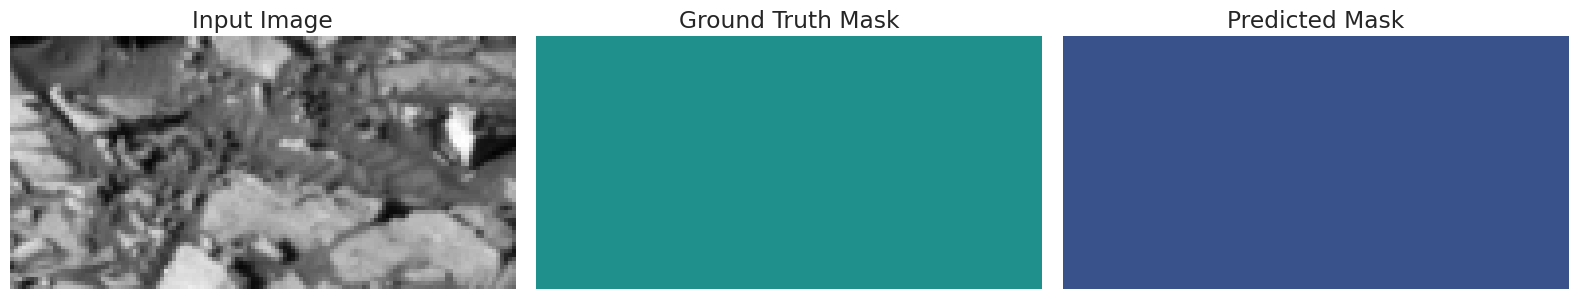

144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.3274 - loss: 0.2852 - mean_iou: 0.1068 - val_accuracy: 0.3401 - val_loss: 0.2513 - val_mean_iou: 0.1117 - learning_rate: 2.0000e-04
Epoch 2/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3433 - loss: 0.2471 - mean_iou: 0.1494 - val_accuracy: 0.4098 - val_loss: 0.2330 - val_mean_iou: 0.2388 - learning_rate: 4.0000e-04
Epoch 3/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3943 - loss: 0.2316 - mean_iou: 0.2570 - val_accuracy: 0.4197 - val_loss: 0.2237 - val_mean_iou: 0.2383 - learning_rate: 6.0000e-04
Epoch 4/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.4263 - loss: 0.2197 - mean_iou: 0.2964 - val_accuracy: 0.4407 - val_loss: 0.2216 - val_mean_iou: 0.2752 - learning_rate: 8.0000e-04
Epoch 5/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.4401 - loss: 0.2181 - mean_iou: 0.3156 - val_accuracy: 0.4543 - val_loss: 0.2143 - val_mean_iou: 0.2900 - learning_rate: 0.0010
Epoch 

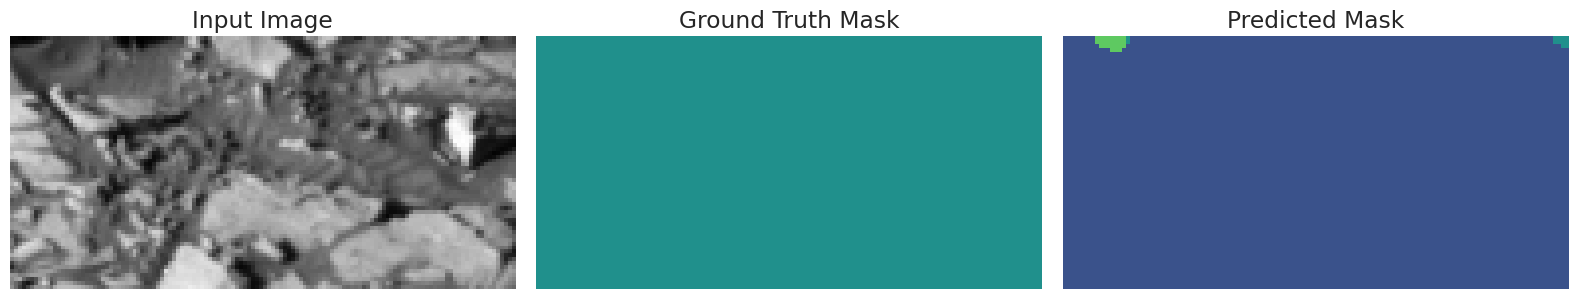

144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4652 - loss: 0.2133 - mean_iou: 0.3380 - val_accuracy: 0.4548 - val_loss: 0.2151 - val_mean_iou: 0.2887 - learning_rate: 0.0010
Epoch 7/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.4864 - loss: 0.2106 - mean_iou: 0.3638 - val_accuracy: 0.4811 - val_loss: 0.2095 - val_mean_iou: 0.3275 - learning_rate: 9.9994e-04
Epoch 8/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.4987 - loss: 0.2094 - mean_iou: 0.3776 - val_accuracy: 0.5060 - val_loss: 0.2055 - val_mean_iou: 0.3616 - learning_rate: 9.9974e-04
Epoch 9/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5175 - loss: 0.2068 - mean_iou: 0.4121 - val_accuracy: 0.5374 - val_loss: 0.2028 - val_mean_iou: 0.4071 - learning_rate: 9.9942e-04
Epoch 10/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5308 - loss: 0.2051 - mean_iou: 0.4386 - val_accuracy: 0.5611 - val_loss: 0.1998 - val_mean_iou: 0.4501 - learning_rate: 9.9896e-04
Epoch

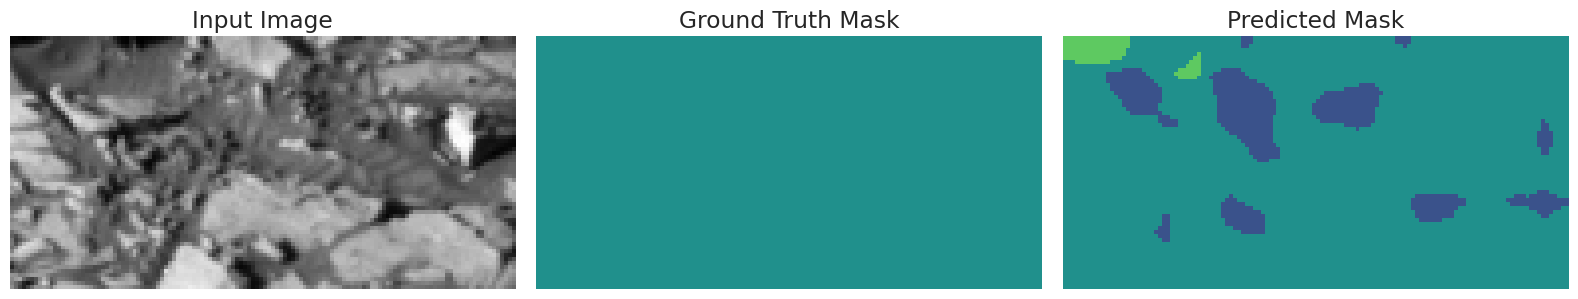

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.5406 - loss: 0.2028 - mean_iou: 0.4561 - val_accuracy: 0.5592 - val_loss: 0.1998 - val_mean_iou: 0.4456 - learning_rate: 9.9838e-04
Epoch 12/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5525 - loss: 0.2011 - mean_iou: 0.4704 - val_accuracy: 0.5933 - val_loss: 0.1951 - val_mean_iou: 0.4866 - learning_rate: 9.9767e-04
Epoch 13/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5567 - loss: 0.2004 - mean_iou: 0.4778 - val_accuracy: 0.5729 - val_loss: 0.1980 - val_mean_iou: 0.4583 - learning_rate: 9.9682e-04
Epoch 14/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5593 - loss: 0.2013 - mean_iou: 0.4778 - val_accuracy: 0.5895 - val_loss: 0.1955 - val_mean_iou: 0.4816 - learning_rate: 9.9585e-04
Epoch 15/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5591 - loss: 0.2002 - mean_iou: 0.4832 - val_accuracy: 0.5996 - val_loss: 0.1955 - val_mean_iou: 0.4964 - learning_rate: 9.9475e-0

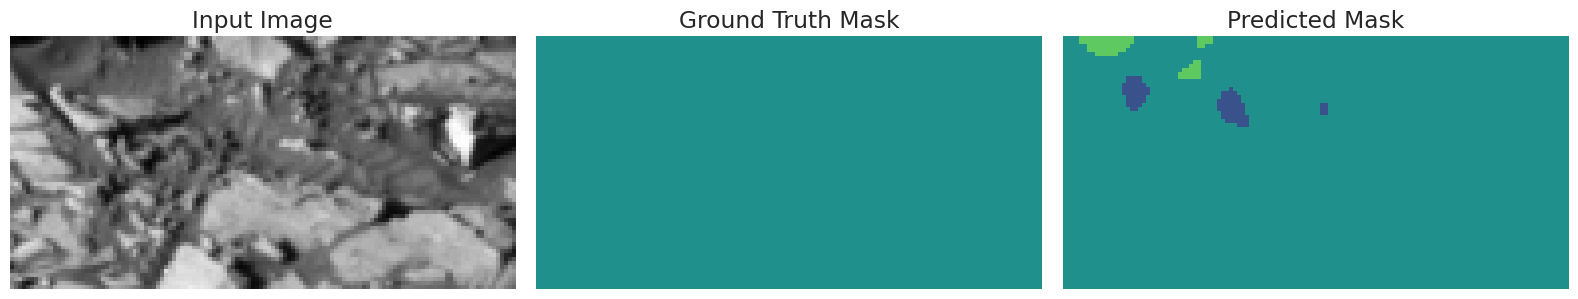

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.5636 - loss: 0.1996 - mean_iou: 0.4876 - val_accuracy: 0.5987 - val_loss: 0.1939 - val_mean_iou: 0.4950 - learning_rate: 9.9353e-04
Epoch 17/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5723 - loss: 0.1979 - mean_iou: 0.4991 - val_accuracy: 0.5888 - val_loss: 0.1955 - val_mean_iou: 0.4763 - learning_rate: 9.9217e-04
Epoch 18/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5800 - loss: 0.1964 - mean_iou: 0.5102 - val_accuracy: 0.6032 - val_loss: 0.1921 - val_mean_iou: 0.4996 - learning_rate: 9.9069e-04
Epoch 19/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5860 - loss: 0.1954 - mean_iou: 0.5188 - val_accuracy: 0.5901 - val_loss: 0.1949 - val_mean_iou: 0.4826 - learning_rate: 9.8907e-04
Epoch 20/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5783 - loss: 0.1970 - mean_iou: 0.5096 - val_accuracy: 0.5910 - val_loss: 0.1952 - val_mean_iou: 0.4809 - learning_rate: 9.8734e-0

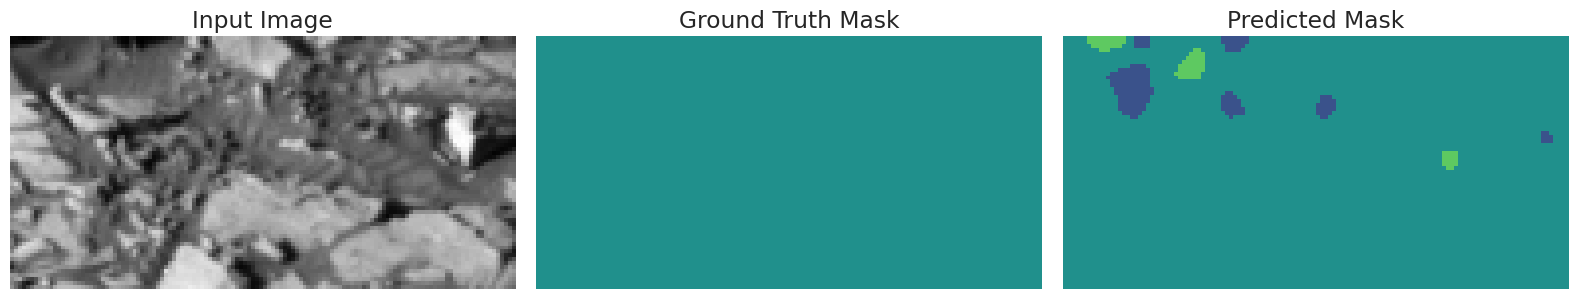

144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.5841 - loss: 0.1952 - mean_iou: 0.5168 - val_accuracy: 0.5617 - val_loss: 0.1997 - val_mean_iou: 0.4474 - learning_rate: 9.8547e-04
Epoch 22/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5798 - loss: 0.1958 - mean_iou: 0.5135 - val_accuracy: 0.5859 - val_loss: 0.1951 - val_mean_iou: 0.4753 - learning_rate: 9.8348e-04
Epoch 23/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5775 - loss: 0.1976 - mean_iou: 0.5064 - val_accuracy: 0.6111 - val_loss: 0.1903 - val_mean_iou: 0.5117 - learning_rate: 9.8136e-04
Epoch 24/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5888 - loss: 0.1949 - mean_iou: 0.5238 - val_accuracy: 0.6193 - val_loss: 0.1896 - val_mean_iou: 0.5208 - learning_rate: 9.7912e-04
Epoch 25/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5906 - loss: 0.1944 - mean_iou: 0.5289 - val_accuracy: 0.6045 - val_loss: 0.1916 - val_mean_iou: 0.4999 - learning_rate: 9.7676e-0

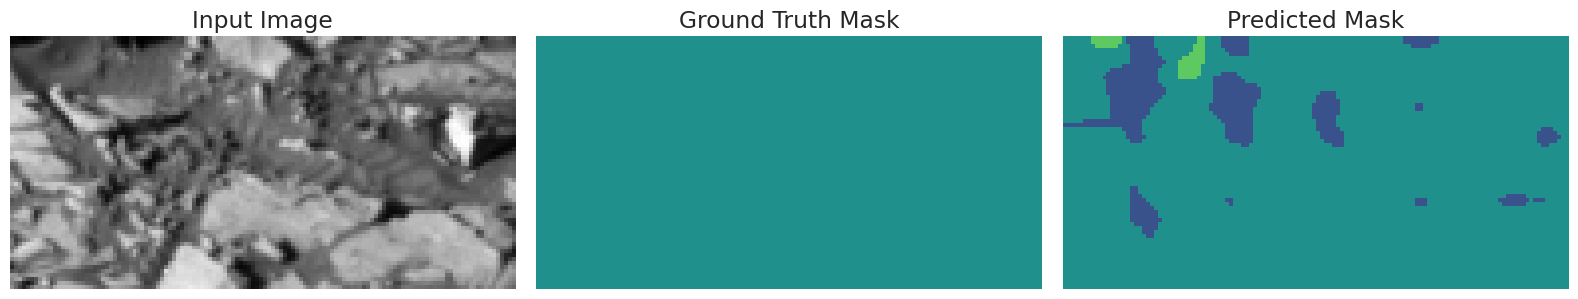

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.5838 - loss: 0.1955 - mean_iou: 0.5230 - val_accuracy: 0.5930 - val_loss: 0.1946 - val_mean_iou: 0.4859 - learning_rate: 9.7427e-04
Epoch 27/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5926 - loss: 0.1942 - mean_iou: 0.5330 - val_accuracy: 0.6121 - val_loss: 0.1904 - val_mean_iou: 0.5111 - learning_rate: 9.7166e-04
Epoch 28/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5991 - loss: 0.1921 - mean_iou: 0.5442 - val_accuracy: 0.5836 - val_loss: 0.1956 - val_mean_iou: 0.4760 - learning_rate: 9.6892e-04
Epoch 29/200
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5934 - loss: 0.1936 - mean_iou: 0.5359
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.000483032432384789.
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5935 - loss: 0.1935 - mean_iou: 0.5360 - val_accuracy: 0.6019 - val_loss: 0.1921 - val_mean_iou: 0.4960 - learning_rate: 9.6606e-04
Epoch 30/200
144/144 ━━━━━━━━

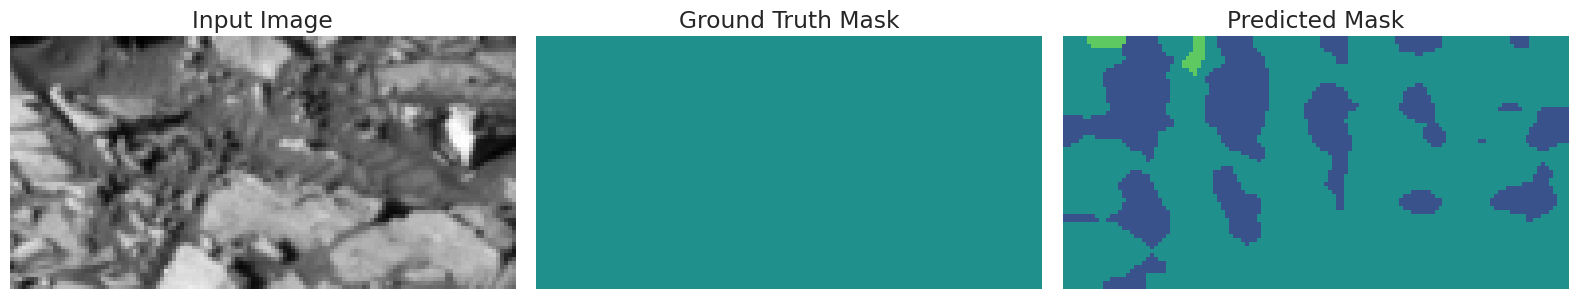

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.5953 - loss: 0.1929 - mean_iou: 0.5399 - val_accuracy: 0.6173 - val_loss: 0.1902 - val_mean_iou: 0.5156 - learning_rate: 9.5999e-04
Epoch 32/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6062 - loss: 0.1904 - mean_iou: 0.5553 - val_accuracy: 0.6095 - val_loss: 0.1926 - val_mean_iou: 0.5012 - learning_rate: 9.5677e-04
Epoch 33/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6107 - loss: 0.1895 - mean_iou: 0.5626 - val_accuracy: 0.6145 - val_loss: 0.1908 - val_mean_iou: 0.5156 - learning_rate: 9.5344e-04
Epoch 34/200
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6078 - loss: 0.1903 - mean_iou: 0.5596
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.000474992033559829.
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6078 - loss: 0.1903 - mean_iou: 0.5596 - val_accuracy: 0.6220 - val_loss: 0.1899 - val_mean_iou: 0.5211 - learning_rate: 9.4998e-04
Epoch 35/200
144/144 ━━━━━━━━

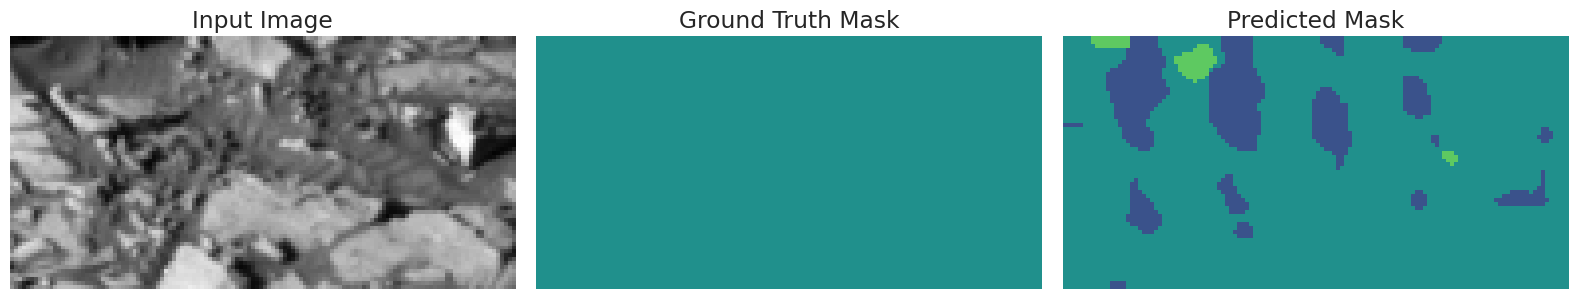

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.6135 - loss: 0.1885 - mean_iou: 0.5702 - val_accuracy: 0.6120 - val_loss: 0.1924 - val_mean_iou: 0.5068 - learning_rate: 9.4273e-04
Epoch 37/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6204 - loss: 0.1871 - mean_iou: 0.5818 - val_accuracy: 0.6072 - val_loss: 0.1947 - val_mean_iou: 0.5002 - learning_rate: 9.3893e-04
Epoch 38/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6202 - loss: 0.1871 - mean_iou: 0.5840 - val_accuracy: 0.5992 - val_loss: 0.1976 - val_mean_iou: 0.4867 - learning_rate: 9.3501e-04
Epoch 39/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6183 - loss: 0.1873 - mean_iou: 0.5825 - val_accuracy: 0.6285 - val_loss: 0.1882 - val_mean_iou: 0.5371 - learning_rate: 9.3099e-04
Epoch 40/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6232 - loss: 0.1862 - mean_iou: 0.5918 - val_accuracy: 0.6083 - val_loss: 0.1947 - val_mean_iou: 0.5027 - learning_rate: 9.2685e-0

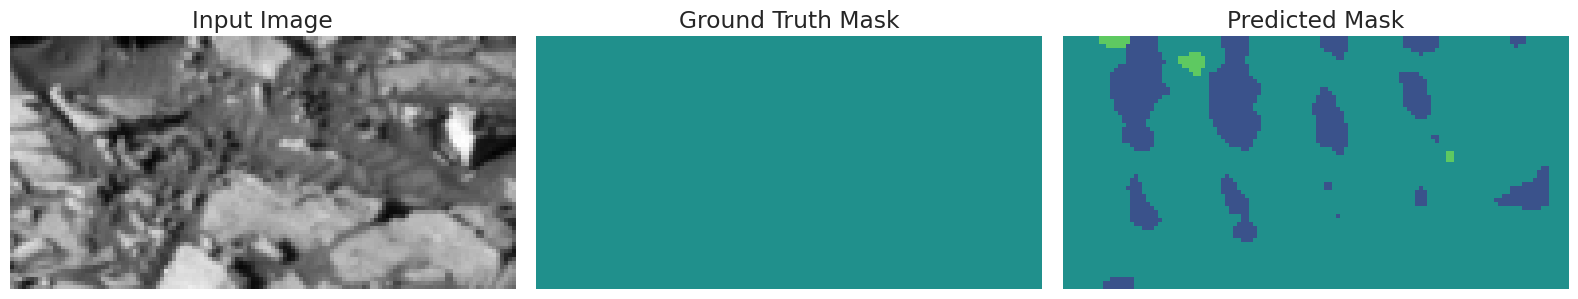

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.6210 - loss: 0.1865 - mean_iou: 0.5926 - val_accuracy: 0.5833 - val_loss: 0.2035 - val_mean_iou: 0.4609 - learning_rate: 9.2260e-04
Epoch 42/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6210 - loss: 0.1864 - mean_iou: 0.5931 - val_accuracy: 0.6046 - val_loss: 0.1945 - val_mean_iou: 0.4950 - learning_rate: 9.1824e-04
Epoch 43/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6265 - loss: 0.1854 - mean_iou: 0.6025 - val_accuracy: 0.6170 - val_loss: 0.1906 - val_mean_iou: 0.5175 - learning_rate: 9.1377e-04
Epoch 44/200
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6272 - loss: 0.1852 - mean_iou: 0.6030
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0004545953997876495.
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6273 - loss: 0.1852 - mean_iou: 0.6029 - val_accuracy: 0.6248 - val_loss: 0.1893 - val_mean_iou: 0.5307 - learning_rate: 9.0919e-04
Epoch 45/200
144/144 ━━━━━━━

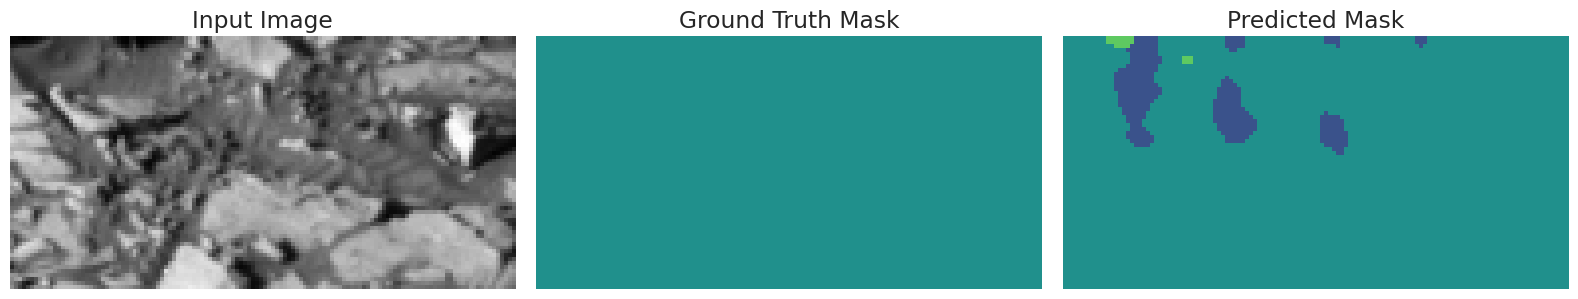

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.6321 - loss: 0.1842 - mean_iou: 0.6152 - val_accuracy: 0.6354 - val_loss: 0.1869 - val_mean_iou: 0.5439 - learning_rate: 8.9972e-04
Epoch 47/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6335 - loss: 0.1837 - mean_iou: 0.6201 - val_accuracy: 0.6096 - val_loss: 0.1957 - val_mean_iou: 0.4959 - learning_rate: 8.9483e-04
Epoch 48/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6300 - loss: 0.1841 - mean_iou: 0.6154 - val_accuracy: 0.6224 - val_loss: 0.1902 - val_mean_iou: 0.5235 - learning_rate: 8.8984e-04
Epoch 49/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6322 - loss: 0.1835 - mean_iou: 0.6237 - val_accuracy: 0.6261 - val_loss: 0.1892 - val_mean_iou: 0.5288 - learning_rate: 8.8474e-04
Epoch 50/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6357 - loss: 0.1829 - mean_iou: 0.6301 - val_accuracy: 0.6357 - val_loss: 0.1871 - val_mean_iou: 0.5419 - learning_rate: 8.7955e-0

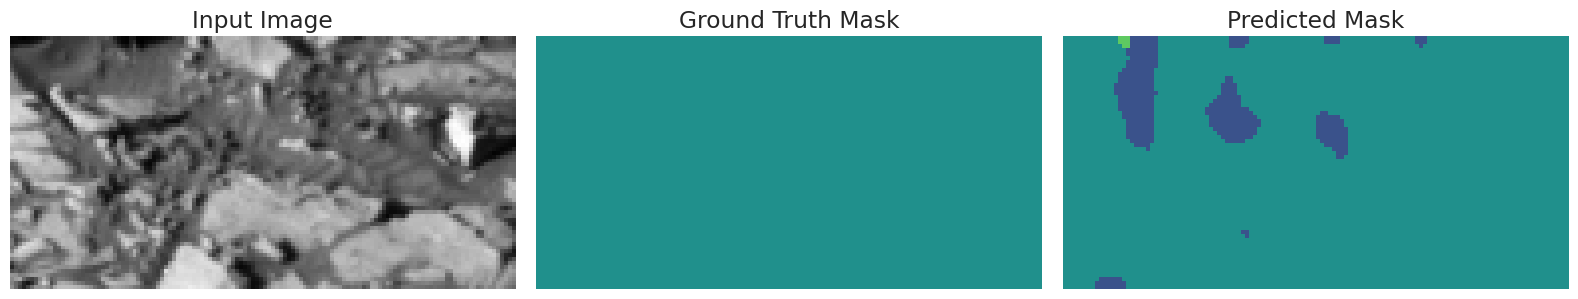

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.6358 - loss: 0.1828 - mean_iou: 0.6329 - val_accuracy: 0.6321 - val_loss: 0.1886 - val_mean_iou: 0.5352 - learning_rate: 8.7426e-04
Epoch 52/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6353 - loss: 0.1826 - mean_iou: 0.6373 - val_accuracy: 0.6203 - val_loss: 0.1909 - val_mean_iou: 0.5184 - learning_rate: 8.6887e-04
Epoch 53/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6328 - loss: 0.1829 - mean_iou: 0.6333 - val_accuracy: 0.6226 - val_loss: 0.1930 - val_mean_iou: 0.5191 - learning_rate: 8.6338e-04
Epoch 54/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6382 - loss: 0.1817 - mean_iou: 0.6458 - val_accuracy: 0.6215 - val_loss: 0.1930 - val_mean_iou: 0.5164 - learning_rate: 8.5780e-04
Epoch 55/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6392 - loss: 0.1815 - mean_iou: 0.6469 - val_accuracy: 0.6027 - val_loss: 0.1998 - val_mean_iou: 0.4868 - learning_rate: 8.5213e-0

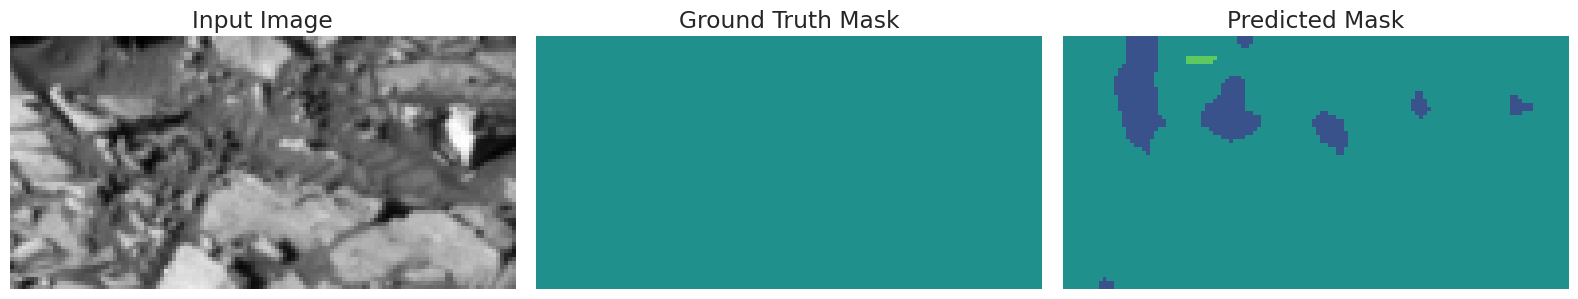

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.6378 - loss: 0.1816 - mean_iou: 0.6500 - val_accuracy: 0.6192 - val_loss: 0.1944 - val_mean_iou: 0.5124 - learning_rate: 8.4636e-04
Epoch 57/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6435 - loss: 0.1804 - mean_iou: 0.6625 - val_accuracy: 0.6181 - val_loss: 0.1966 - val_mean_iou: 0.5083 - learning_rate: 8.4051e-04
Epoch 58/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.6411 - loss: 0.1768 - mean_iou: 0.6432 - val_accuracy: 0.6329 - val_loss: 0.1436 - val_mean_iou: 0.5306 - learning_rate: 8.3457e-04
Epoch 59/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6467 - loss: 0.1374 - mean_iou: 0.5648 - val_accuracy: 0.6237 - val_loss: 0.1465 - val_mean_iou: 0.5156 - learning_rate: 8.2854e-04
Epoch 60/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6479 - loss: 0.1370 - mean_iou: 0.5669 - val_accuracy: 0.6105 - val_loss: 0.1490 - val_mean_iou: 0.4962 - learning_rate: 8.2242e-0

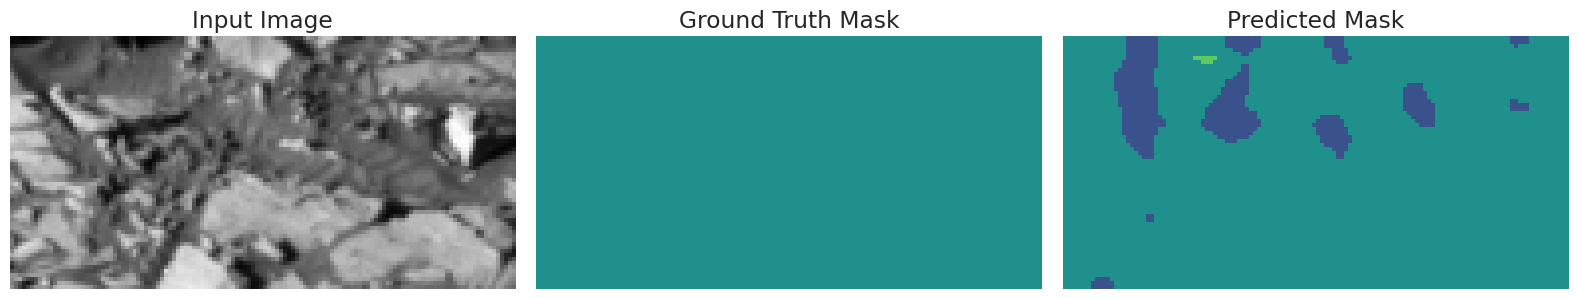

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.6442 - loss: 0.1374 - mean_iou: 0.5613 - val_accuracy: 0.6229 - val_loss: 0.1460 - val_mean_iou: 0.5144 - learning_rate: 8.1622e-04
Epoch 62/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6510 - loss: 0.1361 - mean_iou: 0.5715 - val_accuracy: 0.6325 - val_loss: 0.1436 - val_mean_iou: 0.5300 - learning_rate: 8.0994e-04
Epoch 63/200
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6530 - loss: 0.1356 - mean_iou: 0.5749
Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0004017908067908138.
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6530 - loss: 0.1356 - mean_iou: 0.5748 - val_accuracy: 0.6209 - val_loss: 0.1477 - val_mean_iou: 0.5111 - learning_rate: 8.0358e-04
Epoch 64/200
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6505 - loss: 0.1359 - mean_iou: 0.5709 - val_accuracy: 0.6225 - val_loss: 0.1476 - val_mean_iou: 0.5141 - learning_rate: 7.9714e-04
Epoch 65/200
144/144 ━━━━━━━

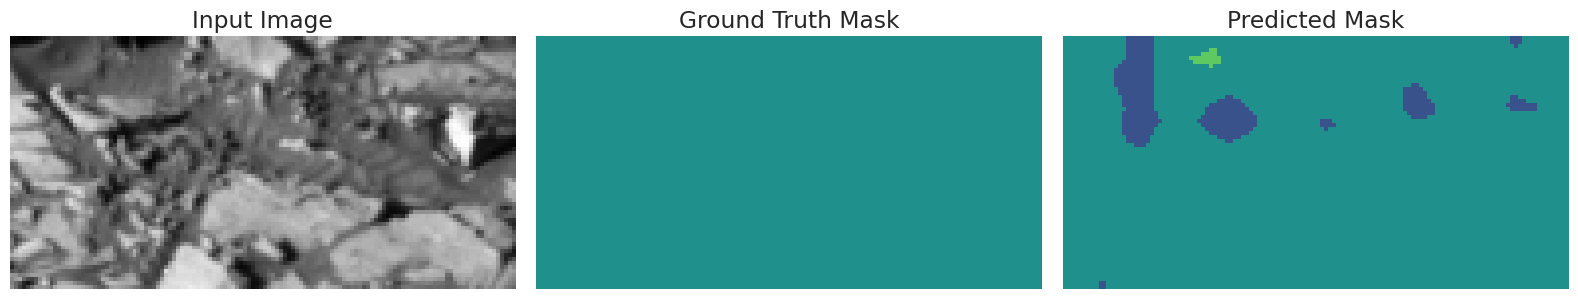

144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6542 - loss: 0.1349 - mean_iou: 0.5766 - val_accuracy: 0.6359 - val_loss: 0.1428 - val_mean_iou: 0.5346 - learning_rate: 7.8403e-04


In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler, reduce_lr, viz_callback, early_stopping],
    verbose=1
).history

In [24]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history.history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 54.39%


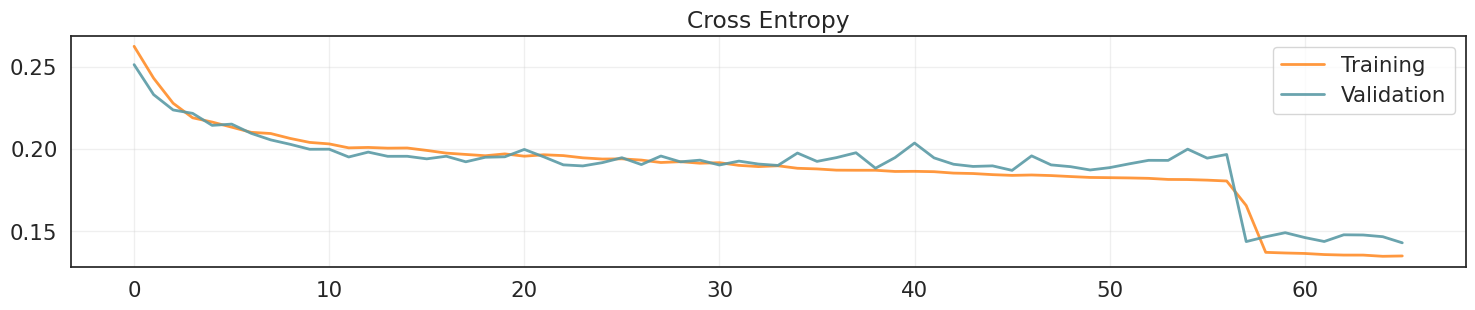

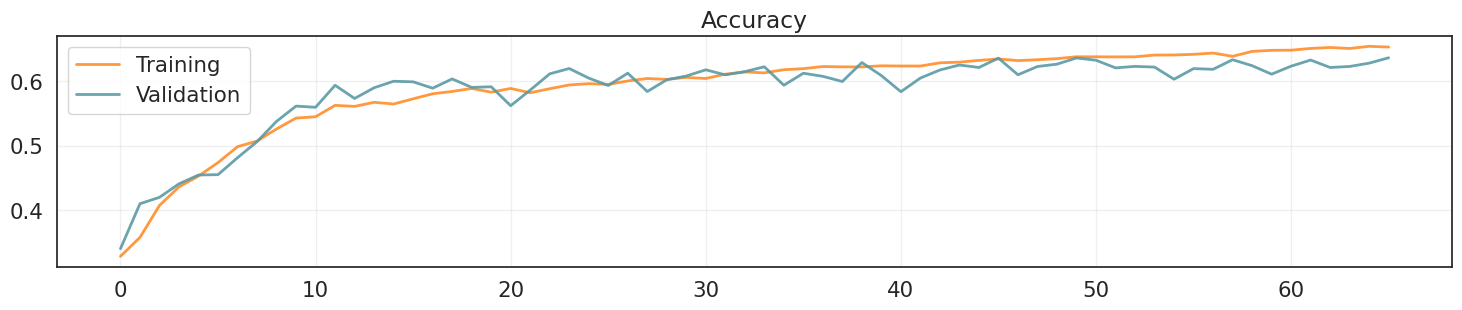

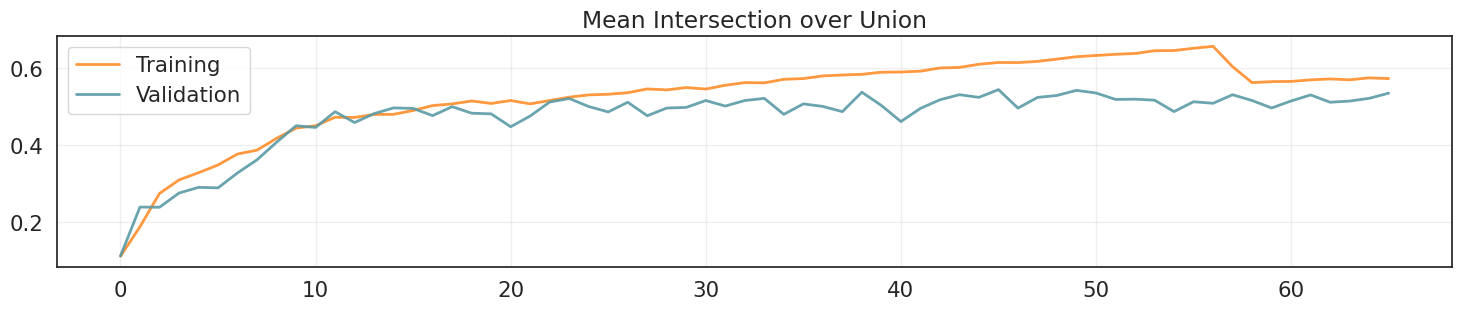

In [26]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history.history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history.history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history.history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [27]:
# path
model_path = "/kaggle/working/UNet_54.39.keras"

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [29]:
model.compile(optimizer="adam", 
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8), 
              metrics=["accuracy", 
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])


In [30]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.6171 - loss: 0.1882 - mean_iou: 0.5403
Loss: 0.186604306101799
Accuracy: 0.6325374245643616
Mean Over Union: 0.5636506080627441


In [31]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [32]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.6225
Class 2: IoU = 0.5178
Class 3: IoU = 0.5524
Class 4: IoU = 0.025


In [33]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [34]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.6914
  Recall = 0.8621
  F1-score = 0.7673
Class 2:
  Precision = 0.5867
  Recall = 0.8151
  F1-score = 0.6823
Class 3:
  Precision = 0.6018
  Recall = 0.8706
  F1-score = 0.7117
Class 4:
  Precision = 0.039
  Recall = 0.0652
  F1-score = 0.0488


# def scheduler(epoch):
    if epoch < warmup_epochs:
        return float((epoch + 1) / warmup_epochs * 1e-3)  # Warm-up
    else:
        return float(1e-3 * 0.5 * (1 + tf.math.cos((epoch - warmup_epochs) / (total_epochs - warmup_epochs) * 3.14159)))  # Cosine annealingdef atrous_conv_block(x, filters, dilation_rate, name):
    """Atrous convolution block with varying dilation rates."""
    atrous = layers.Conv2D(filters, kernel_size=3, dilation_rate=dilation_rate, padding='same', activation='relu', name=name)(x)
    return atrousdef dice_loss(y_true, y_pred, smooth=1.):
    # Assicurati che le etichette siano in formato float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    # Calcola la Dice coefficient (1 - Dice coefficient)
    dice = (2. * intersection + smooth) / (denominator + smooth)
    
    return 1 - diceLoad the training and validation sets (already augmented and split)
train_data = np.load("/kaggle/input/augmented/training_augmented_4x.npz")
X_tr = train_data["X_tr"]
y_tr = train_data["y_tr"]

val_data = np.load("/kaggle/input/augmented/validation_augmented_4x.npz")
X_val = val_data["X_val"]
y_val = val_data["y_val"]

data = np.load("/kaggle/input/testset/mars_for_students.npz")
X_test = data["test_set"]

print("Shapes:")
print(f"X_tr: {X_tr.shape}")
print(f"y_tr: {y_tr.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")

num_classes = 5
input_shape = X_tr.shape[1:]  # e.g. (64, 128, 1)

In [35]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_54.39.keras             "

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [36]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step
Predictions shape: (10022, 64, 128)


In [37]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [38]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_54.39.csv
